# Flame Evolution

Load extracted isocontours in a chosen snapshot range and plot them every `PLOT_EVERY` snapshots.

In [1]:
from __future__ import annotations
from pathlib import Path
import os

os.chdir("../../..")

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from FLAME.io_fronts import Case, load_fronts


In [2]:
PROJECT_ROOT = Path.cwd().resolve()
CONFIG_PATH = PROJECT_ROOT / "notebooks" / "case_studies" / "DMD" / "DMD.yaml"
CFG = yaml.safe_load(CONFIG_PATH.read_text(encoding="utf-8"))

DATA_BASE_DIR = PROJECT_ROOT / Path("data/isocontours")
PHI = float(CFG["PHI"])
LAT_SIZE = str(CFG["LAT_SIZE"])
POST = bool(CFG["POST"])
MULTIPLE_RUNS = bool(CFG.get("MULTIPLE_RUNS", False))
N_RUN = int(CFG.get("N_RUN", 0))

# --- User controls ---
SNAPSHOT_START = 200
SNAPSHOT_END = 300
PLOT_EVERY = 20

# Plot options
ISOLEVEL_TO_PLOT = 0.6
POINT_SIZE = 8
POINT_ALPHA = 0.65

if PLOT_EVERY <= 0:
    raise ValueError("PLOT_EVERY must be > 0")
if SNAPSHOT_END < SNAPSHOT_START:
    raise ValueError("SNAPSHOT_END must be >= SNAPSHOT_START")

SNAPSHOTS = list(range(SNAPSHOT_START, SNAPSHOT_END + 1, PLOT_EVERY))
print(f"Using snapshots: {SNAPSHOTS[:5]} ... {SNAPSHOTS[-5:] if len(SNAPSHOTS) > 5 else SNAPSHOTS}")
print(f"Isolevels: {[ISOLEVEL_TO_PLOT]}")

# Model_verification-like plotting style
PLOT_FONT_FAMILY = str(CFG.get("PLOT_FONT_FAMILY", "CMU Serif"))
PLOT_FONT_SIZE = int(CFG.get("PLOT_FONT_SIZE", 20))
FIG_DPI = int(CFG.get("FIG_DPI", 250))
FIG_SIZE_RAW = CFG.get("FIG_SIZE", (6.8, 6.2))
if isinstance(FIG_SIZE_RAW, (list, tuple)) and len(FIG_SIZE_RAW) == 2:
    FIG_SIZE = (float(FIG_SIZE_RAW[0]), float(FIG_SIZE_RAW[1]))
else:
    FIG_SIZE = (6.8, 6.2)

PLOT_USE_TEX = bool(CFG.get("PLOT_USE_TEX", False))
PLOT_TEX_PREAMBLE_RAW = CFG.get("PLOT_TEX_PREAMBLE", "")
if isinstance(PLOT_TEX_PREAMBLE_RAW, (list, tuple)):
    PLOT_TEX_PREAMBLE = "\n".join(str(item) for item in PLOT_TEX_PREAMBLE_RAW if item)
else:
    PLOT_TEX_PREAMBLE = str(PLOT_TEX_PREAMBLE_RAW) if PLOT_TEX_PREAMBLE_RAW is not None else ""

def apply_plot_style() -> None:
    params = {
        "font.family": PLOT_FONT_FAMILY,
        "font.size": PLOT_FONT_SIZE,
        "axes.titlesize": PLOT_FONT_SIZE,
        "axes.labelsize": PLOT_FONT_SIZE,
        "xtick.labelsize": PLOT_FONT_SIZE,
        "ytick.labelsize": PLOT_FONT_SIZE,
        "legend.fontsize": max(PLOT_FONT_SIZE - 5, 9),
        "figure.titlesize": PLOT_FONT_SIZE,
        "axes.linewidth": 1.2,
        "text.usetex": PLOT_USE_TEX,
        "figure.subplot.left": 0.14,
        "figure.subplot.right": 0.86,
        "figure.subplot.bottom": 0.14,
        "figure.subplot.top": 0.96,
    }
    if PLOT_TEX_PREAMBLE:
        params["text.latex.preamble"] = PLOT_TEX_PREAMBLE
    plt.rcParams.update(params)

def style_axes(ax, *, equal: bool = False) -> None:
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle="-", linewidth=0.75, alpha=0.25)
    ax.grid(True, which="minor", linestyle="-", linewidth=0.25, alpha=0.15)
    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)
    ax.tick_params(axis="both", which="major", length=6, width=1.0)
    ax.tick_params(axis="both", which="minor", length=3, width=0.8)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    if equal:
        ax.set_aspect("equal", adjustable="box")

apply_plot_style()

COLOR_DATA = str(CFG.get("COLOR_DATA", "#77b5b6"))
COLOR_DATA_EDGE = str(CFG.get("COLOR_DATA_EDGE", "#378d94"))
SCATTER_LINEWIDTH = float(CFG.get("SCATTER_LINEWIDTH", 0.05))



Using snapshots: [200, 220, 240, 260, 280] ... [220, 240, 260, 280, 300]
Isolevels: [0.6]


In [3]:
def make_case(time_step: int) -> Case:
    base_kwargs = dict(
        base_dir=DATA_BASE_DIR,
        phi=PHI,
        lat_size=LAT_SIZE,
        time_step=time_step,
        post=POST,
    )
    try:
        return Case(
            **base_kwargs,
            multiple_runs=MULTIPLE_RUNS,
            n_run=N_RUN,
        )
    except TypeError:
        return Case(**base_kwargs)


def load_fronts_for_snapshots(snapshots: list[int], isolevels: list[float]) -> dict[int, dict[float, pd.DataFrame]]:
    data: dict[int, dict[float, pd.DataFrame]] = {}
    for t in snapshots:
        case_t = make_case(t)
        try:
            data[t] = load_fronts(case_t, isolevels, required_cols=["x", "y"])
        except FileNotFoundError as exc:
            print(f"[WARN] Skipping snapshot {t}: {exc}")
    return data


front_data = load_fronts_for_snapshots(SNAPSHOTS, [ISOLEVEL_TO_PLOT])
print(f"Loaded {len(front_data)} snapshots.")


Loaded 6 snapshots.


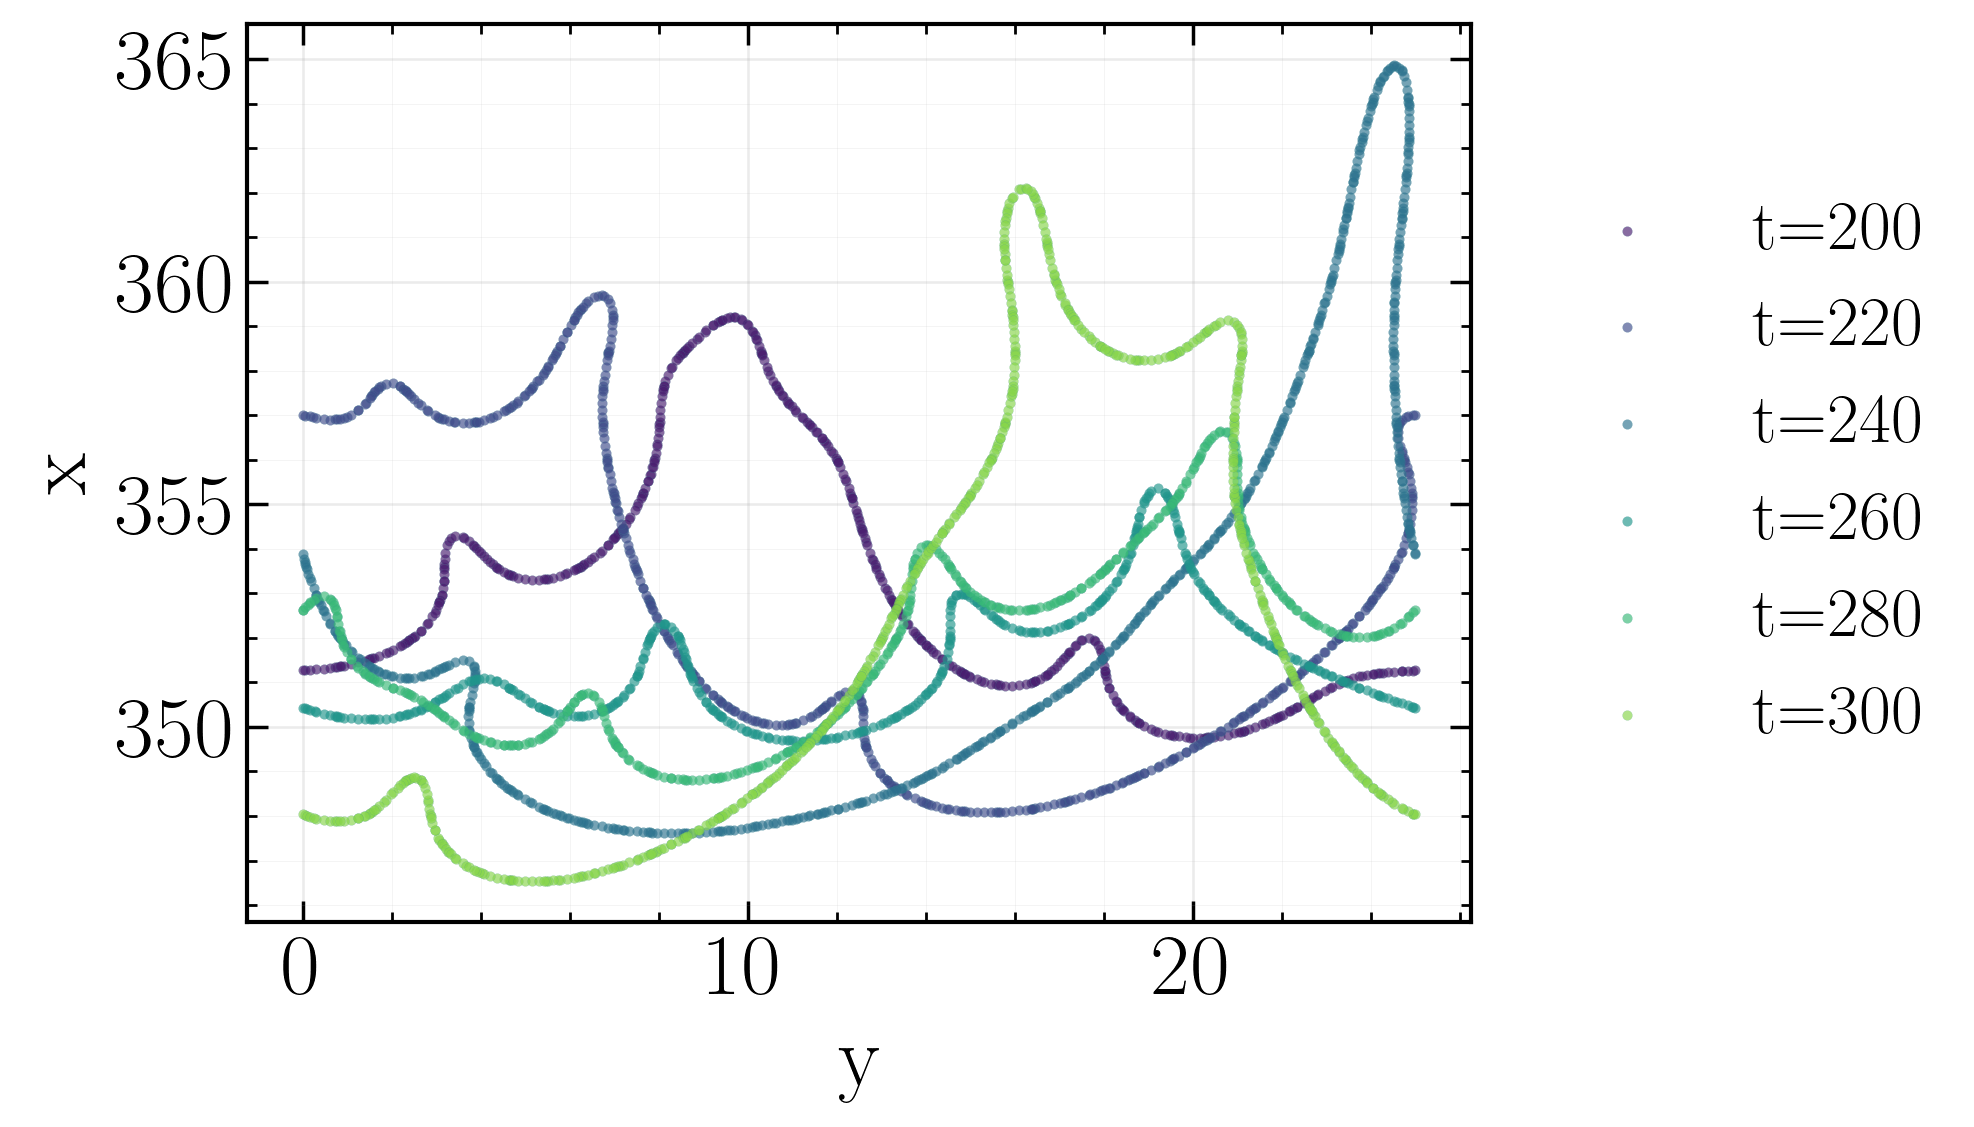

In [6]:
# Combined evolution plot for one selected isolevel (color = snapshot)
fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=False)

times = sorted(front_data)
colors = plt.cm.viridis(np.linspace(0.08, 0.82, max(len(times), 1)))
for color, t in zip(colors, times):
    df = front_data[t].get(float(ISOLEVEL_TO_PLOT))
    if df is None:
        continue
    ax.scatter(
        df["y"],
        df["x"],
        s=POINT_SIZE,
        alpha=POINT_ALPHA,
        color=color,
        edgecolors=COLOR_DATA_EDGE,
        linewidths=SCATTER_LINEWIDTH,
        label=f"t={t}",
        zorder=3,
    )

ax.set_xlabel("y")
ax.set_ylabel("x")
style_axes(ax, equal=True)
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
plt.show()

